# Imports

In [1]:
import numpy as np
import qutip as qtp
import math
import cmath
import matplotlib.pyplot as plt
from qutip import *
from tqdm.notebook import tqdm
from scipy import interpolate
from scipy.integrate import solve_ivp
from scipy.integrate import quad
%matplotlib inline
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
blues = cm.get_cmap('Blues', 10)
import ROfunctions as ro
from ROfunctions import *

<ipython-input-1-c4674bf3da63>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues = cm.get_cmap('Blues', 10)


# Define parameters and system Hamiltonian to extract $\chi$

In [2]:
N = 25 #qubit Hilbert space
M = 10 #resonator Hilbert space

#creation/annihilation operators in qubit subspace
c = destroy(N)
cdag = create(N)

#creation/annihilation operators in resonator subspace
a = destroy(M)
adag = create(M)

rnum = adag * a
resonator_num = tensor(qeye(N), rnum)

#fluxonium energy parameters (GHz)
Ej = 4.75
Ec = 1.25
El = 1.5

#resonator frequency (GHz)
w = 7.0
H_lc = w * (adag * a + 1/2)

#qubit-resonator coupling strength (GHz)
g = 0.05
coupling1 = tensor(c, adag)
coupling2 = tensor(cdag, a)
H_i = g * (coupling1 + coupling2)

#reduced charge and phase operators for fluxonium Hamiltonian
phi_naught = ((8 * Ec) / El)**(1/4)
n_op = (-1j / (math.sqrt(2) * phi_naught)) * (c - cdag)
phi_op = (phi_naught / math.sqrt(2)) * (c + cdag)
phi_op_HC = phi_op.dag()
phi_ext = np.linspace(np.pi, 1.3*np.pi, 101)

Cterm = 4 * Ec * (n_op)**2
Lterm = (1/2) * El * phi_op**2

qubitEdiff_r0 = []
qubitEdiff_r1 = []
resEdiff_q0 = []
resEdiff_q1 = []
chi = []

#loop over flux bias defined by phi_ext
for phi in phi_ext:
    Jterm = -Ej * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
    H_flux = Jterm + Cterm + Lterm
    H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
    states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
    qubitEdiff_r0.append(frequencies[0].real)
    qubitEdiff_r1.append(frequencies[1].real)
    resEdiff_q0.append(frequencies[2].real)
    resEdiff_q1.append(frequencies[3].real)
    chi.append(chi_value.real * 1000)    

# Define global variables

In [3]:
n_readout = 10 #average cavity photon number
kappa = 2 * np.pi * 5 #resonator linewidith

In [4]:
chi_hfqp = 2 * np.pi * chi[0]
chi_readout = 2 * np.pi * chi[-7] #chosen to be at Phi_ext/Phi_0 = 0.641 based on other simulation results

# Calculate SNR for readout at sweet-spot for comparison

In [5]:
tau = np.linspace(0.01, 1, 100) #microseconds
scaledSNR_hfqp, rawSNR_hfqp = SNR(n_readout, kappa, chi_hfqp, tau)

# Interpolation for $\chi$ vs $\Phi_{ext}/\Phi_{0}$

In [6]:
read_phi_ext = phi_ext[:-7] #array of flux bias points between sweet spot and readout
read_chi = chi[:-7] #array of dispersive shift between sweet spot and readout
chi_func_phi = interpolate.interp1d(read_phi_ext, read_chi) #chi as a function of external flux

t = []
for phi in read_phi_ext:
    time = (0.05 / (0.282 * np.pi)) * (phi - np.pi)
    t.append(time)
    
chi_func_t = interpolate.interp1d(t, read_chi, fill_value="extrapolate") #chi as a function of time

# Solve Langevin analytically during 50 ns flux pulse to get $\alpha$

In [7]:
ep = math.sqrt(n_readout*(chi_readout**2 + (kappa)**2 / 4)) #epsilon - drive amplitude

#solve differential equation to get alpha for two eigenstates (|0>, |1>)
def alphadot_0(alpha, time):
    dalpha0dt = -1j * 2 * np.pi * chi_func_t(time) * alpha - (1/2) * kappa * alpha + ep
    return dalpha0dt

def alphadot_1(alpha, time):
    dalpha1dt = 1j * 2 * np.pi * chi_func_t(time) * alpha - (1/2) * kappa * alpha + ep
    return dalpha1dt

alpha_init = [0+0j]
t_fp = np.linspace(0, 0.05, 101) #times during flux pulse

sol_alpha0 = solve_ivp(lambda time, alpha: alphadot_0(alpha, time), [t_fp[0], t_fp[-1]], alpha_init, t_eval=t_fp)
sol_alpha1 = solve_ivp(lambda time, alpha: alphadot_1(alpha, time), [t_fp[0], t_fp[-1]], alpha_init, t_eval=t_fp)

alpha0solution = sol_alpha0.y[0]
alpha1solution = sol_alpha1.y[0]

# Transformation of $\alpha$ to $\alpha_{out}$ using interpolation during flux pulse

In [8]:
alpha_out_0 = []
alpha_out_1 = []

#calculation of alpha_out from alpha and alpha_in
for a in alpha0solution:
    aout0 = (-ep / math.sqrt(kappa)) + math.sqrt(kappa) * a
    alpha_out_0.append(aout0)

for b in alpha1solution:
    aout1 = (-ep / math.sqrt(kappa)) + math.sqrt(kappa) * b
    alpha_out_1.append(aout1)
    
aout0_func = interpolate.interp1d(t_fp, alpha_out_0, fill_value="extrapolate")
aout1_func = interpolate.interp1d(t_fp, alpha_out_1, fill_value="extrapolate")

#_fp indicates with flux pulse
scaledSNR_fp = [] #scaled by average photon number population
rawSNR_fp = []

#integration to get measurement operator which allows for calculation of SNR
for t in t_fp:
    M_fp = []
    tpts = np.linspace(0,t,1001)
    for i in tpts:
        alpha_zero = aout0_func(i)
        alpha_one = aout1_func(i)
        M_fp.append(alpha_zero-alpha_one)
    SNRnumerator = np.sqrt(kappa)*abs(np.trapz(M_fp))*np.diff(tpts)[0]
    SNRdenominator = math.sqrt(kappa * t)
    SNR_fp = SNRnumerator / SNRdenominator
    rawSNR_fp.append(SNR_fp)
    scaledSNR_fp.append(SNR_fp / math.sqrt(n_readout))

<ipython-input-8-5f7c3a4b3de3>:30: RuntimeWarning: invalid value encountered in double_scalars
  SNR_fp = SNRnumerator / SNRdenominator


# Solve Langevin equation for $\alpha$ and calculate SNR post 50 ns flux pulse

In [9]:
def alphadot_0_ap(alpha, time): #after flux pulse
    dalpha0dt_ap = -1j * chi_readout * alpha - (1/2) * kappa * alpha + ep
    return dalpha0dt_ap

def alphadot_1_ap(alpha, time): #after flux pulse
    dalpha1dt_ap = 1j * chi_readout * alpha - (1/2) * kappa * alpha + ep
    return dalpha1dt_ap

#initial point defined as last point during flux pulse
alpha_init_0 = [alpha0solution[-1]]
alpha_init_1 = [alpha1solution[-1]]

t_ap = np.linspace(0.05, 1, 1901) #times after flux pulse, up to 1 us

#solve differential equation to get alpha
sol_alpha0_ap = solve_ivp(lambda time, alpha: alphadot_0_ap(alpha, time), [t_ap[0], t_ap[-1]], alpha_init_0, t_eval=t_ap)
sol_alpha1_ap = solve_ivp(lambda time, alpha: alphadot_1_ap(alpha, time), [t_ap[0], t_ap[-1]], alpha_init_1, t_eval=t_ap)

alpha0solution_ap = sol_alpha0_ap.y[0]
alpha1solution_ap = sol_alpha1_ap.y[0]

aout0 = []
aout1 = []

#calculation of alpha_out from alpha and alpha_in
for a in alpha0solution_ap:
    alphaout0 = (-ep / math.sqrt(kappa)) + math.sqrt(kappa) * a
    aout0.append(alphaout0)

for b in alpha1solution_ap:
    alphaout1 = (-ep / math.sqrt(kappa)) + math.sqrt(kappa) * b
    aout1.append(alphaout1)
    
aout0_func_ap = interpolate.interp1d(t_ap, aout0, fill_value="extrapolate")
aout1_func_ap = interpolate.interp1d(t_ap, aout1, fill_value="extrapolate")

scaledSNR_ap = []
rawSNR_ap = []

#integration to get measurement operator which allows for calculation of SNR post flux pulse
for t in t_ap:
    M = []
    tps = np.linspace(0,t,1001)
    for tp in tps:
        alpha_zero = aout0_func_ap(tp) if tp>0.05 else aout0_func(tp)
        alpha_one = aout1_func_ap(tp) if tp>0.05 else aout1_func(tp)
        M.append(alpha_zero-alpha_one)
    SNRnum = np.sqrt(kappa) * abs(np.trapz(M)*np.diff(tps)[0])
    SNRdenom = math.sqrt(kappa * t)
    SNR = SNRnum / SNRdenom
    rawSNR_ap.append(SNR)
    scaledSNR_ap.append(SNR / math.sqrt(n_readout))

#concatenate time and SNR arrays to capture during and after flux pulse
totalTime = np.concatenate((t_fp, t_ap))
totalRawSNR = np.concatenate((rawSNR_fp, rawSNR_ap))
totalScaledSNR = np.concatenate((scaledSNR_fp, scaledSNR_ap))

# Calculate readout fidelity/error

In [10]:
fidelity_hfqp = []
error_hfqp = []
fidelity_pulse = []
error_pulse = []

#readout at sweet-spot
for i in rawSNR_hfqp:
    fid = (1 - (math.erfc(i/2)/2))
    fidelity_hfqp.append(fid)
    error = (math.erfc(i/2)/2)
    error_hfqp.append(error)
#readout with flux pulse
for i in totalRawSNR:
    fid = (1 - (math.erfc(i/2)/2))
    fidelity_pulse.append(fid)
    error = (math.erfc(i/2)/2)
    error_pulse.append(error)

# Adding <100% measurement efficiency

In [11]:
eta = 0.25
snr_loweff = np.sqrt(eta)*totalRawSNR

error_loweff = []

for i in snr_loweff:
    error = (math.erfc(i/2)/2)
    error_loweff.append(error)

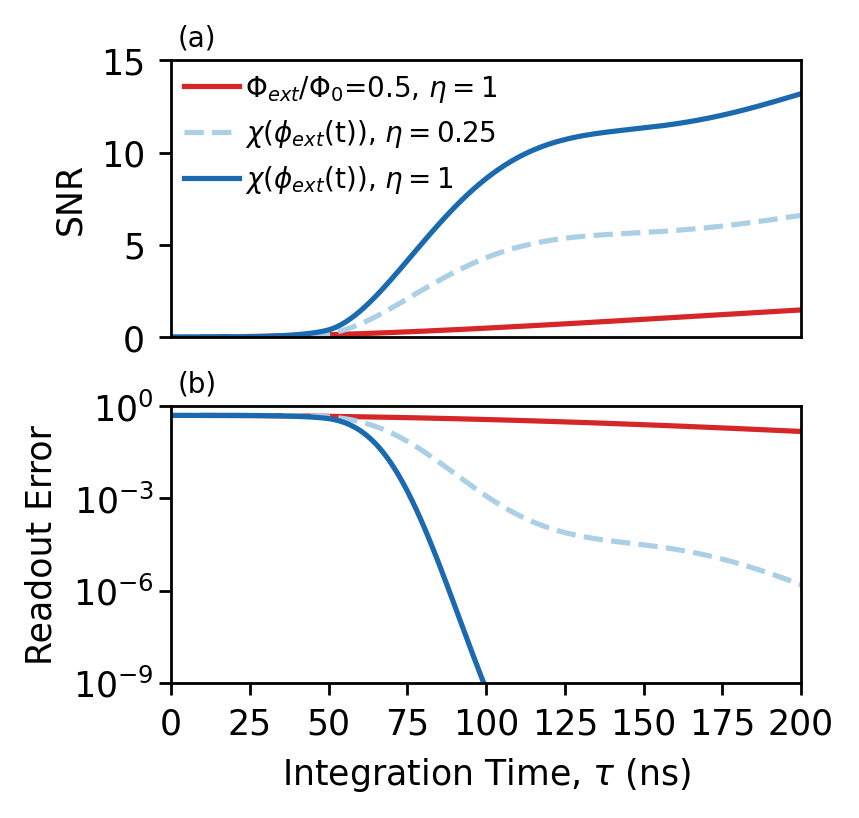

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, dpi=250, sharex=True)

fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.9, wspace=0.4, hspace=0.25)
fig.set_size_inches(3.40457, 3.0)
font = {'size' : 8}
mpl.rc('font', **font)

ax1.plot(tau * 1000, rawSNR_hfqp, label = "$\Phi_{ext}/\Phi_{0}$=0.5, $\eta = 1$", color="tab:red", linewidth=1.5)
ax1.plot(totalTime * 1000, snr_loweff, '--', label = "$\chi$($\phi_{ext}$(t)), $\eta = 0.25$", color=blues(0.35), linewidth=1.5)
ax1.plot(totalTime * 1000, totalRawSNR, label = "$\chi$($\phi_{ext}$(t)), $\eta = 1$", color=blues(0.75), linewidth=1.5)
ax1.set_ylabel(r"SNR")
ax1.set_xlim(0, 200)
ax1.set_ylim(0, 15)
ax1.set_yticks([0.0, 5.0, 10.0, 15.0])
ax1.tick_params(axis='y', pad=4)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.legend(loc='lower left', bbox_to_anchor=(-0.02, 0.42), handletextpad=0.2, frameon=False)
ax1.annotate("(a)", xy=(0.01, 1.05), xycoords="axes fraction")

ax2.plot(tau * 1000, error_hfqp, label = "$\Phi_{ext}/\Phi_{0}$=0.5, $\eta = 1$", color="tab:red", linewidth=1.5)
ax2.plot(totalTime * 1000, error_loweff, '--', label = "$\chi$($\phi_{ext}$,(t)), $\eta = 0.25$", color=blues(0.35), linewidth=1.5)
ax2.plot(totalTime * 1000, error_pulse, label = "$\chi$($\phi$,(t)), $\eta = 1$", color=blues(0.75), linewidth=1.5)
ax2.set_ylabel(r"Readout Error")
ax2.set_xlabel(r"Integration Time, $\tau$ (ns)")
ax2.set_xlim(0, 200) #nanoseconds
ax2.set_yscale("log")
ax2.set_ylim(1e-9, 1)
ax2.tick_params(axis='y', pad=1.5)
ax2.set_xticks([0, 25, 50, 75, 100, 125, 150, 175, 200])
ax2.set_xticklabels([0, 25, 50, 75, 100, 125, 150, 175, 200])
ax2.annotate("(b)", xy=(0.01, 1.05), xycoords="axes fraction")

plt.show()